In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import *
from keras.models import Sequential, Model
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
import librosa
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, accuracy_score
sr = 16000
batch_size = 16

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660, compute capability 7.5


In [2]:
X = []
y = []
for i, td in enumerate(os.listdir('./splits')):
    label = i
    print('Class', td, ':', len(os.listdir('./splits/'+td)), 'audio files')
    files = os.listdir('./splits/'+td)
    for k in range(len(files)):
        files[k] = './splits/'+td +'/'+ files[k]
    for j in range(len(files)):
        y.append(label)
    X = X + files

Class Construction : 3442 audio files
Class Crowd : 3811 audio files
Class Traffic : 1619 audio files


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [4]:
print(len(X_train))
len(X_val)

5677


1420

In [5]:
epochs = 20

In [6]:
def loader_MFCC(audio_list, audio_list_labels):
    L = len(audio_list)
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < L:
            limit = min(batch_end, L)
            z = np.zeros((len(audio_list[batch_start:limit]), 128, 400))
            for i, f in enumerate(audio_list[batch_start:limit]):
                f = f.replace("./splits/", "./mfcc/") + ".npy"
                z[i, :, :] = np.load(f)
            X = np.expand_dims(z, axis=-1)
            Y = np.array(audio_list_labels[batch_start:limit])
            yield (X,Y)
            batch_start += batch_size   
            batch_end += batch_size
            
train_loader_MFCC = loader_MFCC(X_train, y_train)
val_loader_MFCC = loader_MFCC(X_val, y_val)

In [7]:
def res_block(x, f):
    conv = Conv2D(f, 3, strides=1, padding='same')(x)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    
    conv = Conv2D(f, 3, strides=1, padding='same')(conv)
    conv = BatchNormalization()(conv)
    
    identity = Conv2D(f, 1, strides=1, padding='same')(x)
    identity = BatchNormalization()(identity)
    
    conv = Add()([conv, identity])
    conv = Activation('relu')(conv)
    
    return conv
    
def blocks(x, f = 8):
    conv = res_block(x, f)
    conv = MaxPooling2D()(conv)
    
    conv = res_block(conv, f*2)
    conv = MaxPooling2D()(conv)
    
    conv = res_block(conv, f*4)
    conv = MaxPooling2D()(conv)
    
    conv = res_block(conv, f*8)
    conv = MaxPooling2D()(conv)
    
    conv = res_block(conv, f*16)
    conv = MaxPooling2D()(conv)
    
    conv = res_block(conv, f*32)
    
    
    gap = GlobalAveragePooling2D()(conv)
    
    return gap



In [8]:
def CNN_MFCC():

    x = Input(shape=(128,400,1,))
    
    
    gap = blocks(x, f=8)
    
    final = Dense(3, activation='softmax')(gap)

    

    model = Model(inputs=x, outputs=final)
    
    return model

model_MFCC_CNN = CNN_MFCC()

model_MFCC_CNN.summary()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="auto", name="sparse_categorical_crossentropy"
)

metrics = ['accuracy']
optimizer = Adam(0.0001)

media_start = './'
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=20,
    verbose=1,
    mode="auto"
)

filepath= media_start+"MFCC.hdf5"

checkpoint = ModelCheckpoint(filepath, save_freq="epoch",save_best_only=True,
    save_weights_only=True, monitor='val_loss', verbose=1)

csv_logger = CSVLogger(media_start+"MFCC-log.csv")


model_MFCC_CNN.compile(optimizer = optimizer, loss=loss, metrics=metrics)

train_steps = len(X_train)//batch_size
val_steps = len(X_val)//batch_size



history_MFCC = model_MFCC_CNN.fit(train_loader_MFCC,
        steps_per_epoch=train_steps,
        epochs=epochs,
        verbose=1,
        validation_data=val_loader_MFCC,
        validation_steps=val_steps,
        callbacks=[checkpoint, csv_logger]
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 400, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 400, 8)  80          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 400, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

 activation_6 (Activation)      (None, 16, 50, 64)   0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv2d_10 (Conv2D)             (None, 16, 50, 64)   36928       ['activation_6[0][0]']           
                                                                                                  
 conv2d_11 (Conv2D)             (None, 16, 50, 64)   2112        ['max_pooling2d_2[0][0]']        
                                                                                                  
 batch_normalization_10 (BatchN  (None, 16, 50, 64)  256         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 16, 50, 64)  256         ['conv2d_11[0][0]']              
 ormalizat

Epoch 4/20
354/354 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.9991
Epoch 4: val_loss improved from 0.00293 to 0.00207, saving model to .\MFCC.hdf5
354/354 [==============================] - 25s 72ms/step - loss: 0.0045 - accuracy: 0.9991 - val_loss: 0.0021 - val_accuracy: 0.9993
Epoch 5/20
354/354 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 0.9996
Epoch 5: val_loss did not improve from 0.00207
354/354 [==============================] - 25s 72ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0025 - val_accuracy: 0.9993
Epoch 6/20
354/354 [==============================] - ETA: 0s - loss: 5.1385e-04 - accuracy: 1.0000
Epoch 6: val_loss improved from 0.00207 to 0.00152, saving model to .\MFCC.hdf5
354/354 [==============================] - 25s 72ms/step - loss: 5.1385e-04 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 7/20
354/354 [==============================] - ETA: 0s - loss: 3.5362e-04 - accuracy: 1.000

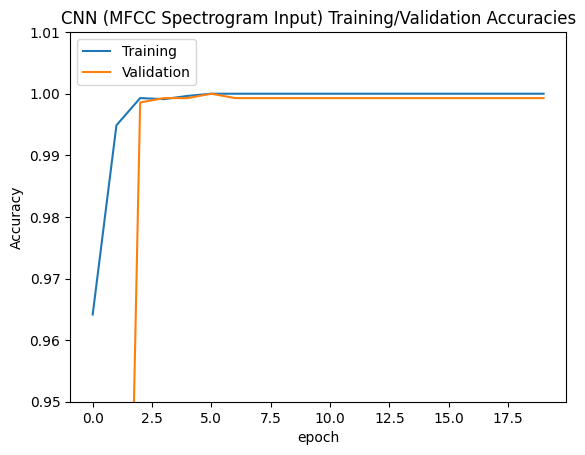

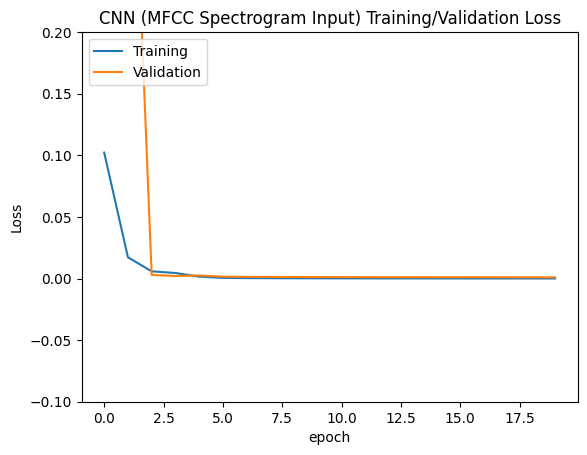

In [18]:
plt.plot(history_MFCC.history['accuracy'])
plt.plot(history_MFCC.history['val_accuracy'])
plt.title('CNN (MFCC Spectrogram Input) Training/Validation Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.ylim(0.95, 1.01)
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_MFCC.history['loss'])
plt.plot(history_MFCC.history['val_loss'])
plt.title('CNN (MFCC Spectrogram Input) Training/Validation Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.ylim(-0.1, 0.2)
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [10]:
# Loading best model weights
model_MFCC_CNN.load_weights('MFCC.hdf5')

predictions_MFCC_CNN = np.zeros((len(X_test), 3))

for i, f in enumerate(X_test):
    data = np.load(f.replace("./splits/", "./MFCC/") + ".npy")
    data = np.expand_dims(np.expand_dims(data, axis=-1), axis=0)
    p = model_MFCC_CNN.predict(data, verbose=0)
    predictions_MFCC_CNN[i, :] = p
    
print("FOR MFCC")
y_pred_MFCC_CNN = np.argmax(predictions_MFCC_CNN, axis=1)
print(classification_report(y_test, y_pred_MFCC_CNN))
print(accuracy_score(y_test, y_pred_MFCC_CNN))

FOR MFCC
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       689
           1       1.00      1.00      1.00       762
           2       1.00      1.00      1.00       324

    accuracy                           1.00      1775
   macro avg       1.00      1.00      1.00      1775
weighted avg       1.00      1.00      1.00      1775

1.0
